In [2]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv()
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    bsm_vol_est_brute_force,
    bsm_vol_est_minimization,
    vector_vol_estimation
)
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    vectorized_market_forward_calc
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
  
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    estimate_crr_implied_volatility,
    vol_est_brute_force_bjs_2002,
    vector_vol_estimation
)
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    get_vectorized_dividend_rate,
    get_vectorized_dividend_scehdule
)

from module_test.raw_code.optionlib_2.assets.dividend import (
    vector_convert_to_time_frac
)

from module_test.raw_code.optionlib_2.greeks.numerical.bjs2002 import (
    bjs2002_numerical_greeks,
)

from module_test.raw_code.optionlib_2.greeks.numerical.binomial import (
    binomial_tree_greeks,
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
import numpy as np
from trade.assets.rates import get_risk_free_rate_helper
from module_test.raw_code.optionlib_2.utils.batch_operation import vector_batch_processor
# os.environ['PROXY_URL'] = ''
from dbase.DataAPI.ThetaData import (
    list_contracts,
    retrieve_eod_ohlc,
    retrieve_chain_bulk
)
def get_spot(tick, date):
    return retrieve_timeseries(tick, date, date)['close'][0]
test_start, test_valuation_date = '2025-07-16', '2025-07-16'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
np.__version__

'2.2.0'

In [4]:
from pydantic import BaseModel, field_validator, computed_field, validate_call
from pydantic.dataclasses import dataclass

In [5]:
import pandas as pd
pd.options.plotting.backend = "plotly"

from dotenv import load_dotenv  
load_dotenv(override=True)
os.environ['PROXY_URL']

'http://54.205.248.219:5500/thetadata'

In [6]:
ticks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
test_start, test_valuation_date = '2025-07-16', '2025-07-16'
def pick_random_option(tick, date):
    contracts = list_contracts(tick, date)
    # Pick a random contract from the list
    contract = np.random.choice(contracts.index)
    return contracts.iloc[contract]

def get_option_eod_price(date, contract_series):
    """
    Retrieves the end-of-day price for a given option contract on a specific date.
    
    Args:
        date (datetime): The date for which to retrieve the price.
        contract_series (pd.Series): The series containing option contract details.
        
    Returns:
        float: The end-of-day price of the option contract.
    """
    eod_data = retrieve_eod_ohlc(symbol=contract_series['root'],
                                  end_date=date,
                                  start_date=date,
                                  exp=str(contract_series['expiration']),
                                  right=contract_series['right'],
                                  strike=contract_series['strike'],
                                  )
    return eod_data.Midpoint[0]

def get_spot(tick, date):
    return retrieve_timeseries(tick, date, date)['close'][0]

# contract = pick_random_option(ticks[0], test_start)
# eod = get_option_eod_price(test_start, contract)
spot = retrieve_timeseries(ticks[0], test_start, test_start)['close'][0]
rates = get_risk_free_rate_helper()['annualized'][test_start]


YF.download() has changed argument auto_adjust default to True
[get_engine] Creating engine for DB: securities_master, PID: 73606


In [7]:
aapl_chain=retrieve_chain_bulk(
    'AAPL',
    0,
    change_to_last_busday(test_valuation_date),
    change_to_last_busday(test_valuation_date),
    '16:00'
)
S = get_spot('AAPL', (test_valuation_date))

In [8]:
aapl_chain = aapl_chain[aapl_chain['Expiration'] >= test_valuation_date]
valuation_dates = [test_valuation_date] * len(aapl_chain)
end_dates = aapl_chain['Expiration'].tolist()
r = [rates] * len(aapl_chain)
s = [S] * len(aapl_chain)
tickers = ['AAPL'] * len(aapl_chain)
F = vectorized_market_forward_calc(
    ticks=tickers,
    S=s,
    valuation_dates=valuation_dates,
    end_dates=end_dates,
    r=r,
    div_type='discrete'
)
F

array([210.8236422 , 210.99470237, 210.8236422 , ..., 210.48193779,
       217.46835885, 217.46835885], shape=(2428,))

In [9]:
T = [time_distance_helper(end_dates[i], valuation_dates[i]) for i in range(len(aapl_chain))]
q = get_vectorized_dividend_rate(
    tickers=tickers,
    spots=s,
    valuation_dates=valuation_dates,
)


discrete_q = get_vectorized_dividend_scehdule(
    tickers=['AAPL'] * len(aapl_chain),
    valuation_dates=[test_valuation_date] * len(aapl_chain),
    end_dates=aapl_chain['Expiration'].tolist(),
    start_dates=[test_valuation_date] * len(aapl_chain),
)

discrete_q_convert = vector_convert_to_time_frac(
    discrete_q, 
    valuation_dates=[test_valuation_date] * len(aapl_chain), 
    end_dates=aapl_chain['Expiration'].tolist(), 
)

In [10]:
params = list(zip(
    F, 
    aapl_chain['Strike'], 
    T,
    r, 
    aapl_chain['Midpoint'], 
    aapl_chain['Right'].str.lower()
))


In [11]:
aapl_chain['S'] = S
aapl_chain['moneyness'] = aapl_chain['Strike'] / S
aapl_chain

,Root,Expiration,Strike,Right,Bid_size,CloseBid,Ask_size,CloseAsk,Date,Midpoint,Weighted_midpoint,S,moneyness
datetime,,,,,,,,,,,,,
2025-07-16,AAPL,2025-08-22,215.0,P,1,9.75,38,10.15,20250716,9.950,10.139744,209.921768,1.024191
2025-07-16,AAPL,2025-08-29,215.0,C,2,6.25,1,6.40,20250716,6.325,6.300000,209.921768,1.024191
2025-07-16,AAPL,2025-08-22,215.0,C,2,5.65,1,5.75,20250716,5.700,5.683333,209.921768,1.024191
2025-07-16,AAPL,2025-08-29,215.0,P,24,9.90,23,10.60,20250716,10.250,10.242553,209.921768,1.024191
2025-07-16,AAPL,2025-09-19,215.0,P,8,11.25,1,11.40,20250716,11.325,11.266667,209.921768,1.024191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,AAPL,2025-07-25,215.0,P,4,5.90,30,6.10,20250716,6.000,6.076471,209.921768,1.024191
2025-07-16,AAPL,2025-08-08,215.0,C,6,4.45,12,4.55,20250716,4.500,4.516667,209.921768,1.024191
2025-07-16,AAPL,2025-08-08,215.0,P,4,8.55,6,8.85,20250716,8.700,8.730000,209.921768,1.024191


In [12]:
T = [time_distance_helper(end_dates[i], valuation_dates[i]) for i in range(len(aapl_chain))]
aapl_chain['T'] = T
aapl_chain['F'] = F
aapl_chain['log_moneyness'] = np.log(aapl_chain['F']/aapl_chain['Strike'])
aapl_chain['T']

datetime
2025-07-16    0.101300
2025-07-16    0.120465
2025-07-16    0.101300
2025-07-16    0.120465
2025-07-16    0.177960
                ...   
2025-07-16    0.024641
2025-07-16    0.062971
2025-07-16    0.062971
2025-07-16    0.922656
2025-07-16    0.922656
Name: T, Length: 2428, dtype: float64

In [13]:
full_vol = vector_vol_estimation(bsm_vol_est_brute_force, params)


In [14]:
aapl_chain['bs_vol'] = full_vol

## Binomial Tree Vol

In [15]:
from module_test.raw_code.optionlib_2.utils.batch_operation import vector_batch_processor
crr_vector_params_discrete = list(zip(
    s, aapl_chain['Strike'].tolist(), ## Spot, Strike
    T, r,  ## Time to Maturity, Risk Free Rate
    aapl_chain['Midpoint'], ## Midpoint Price
    discrete_q_convert, ## Discrete Dividend Schedules
    aapl_chain['Right'].str.lower().tolist(), ## Option Type
    [250] * len(aapl_chain),  ## Number of Steps
    ['discrete'] * len(aapl_chain), ## Dividend Type
    [True] * len(aapl_chain),)) ## American==True, European==False

crr_vector_params_cont = list(zip(
    s, aapl_chain['Strike'].tolist(), ## Spot, Strike
    T, r,  ## Time to Maturity, Risk Free Rate
    aapl_chain['Midpoint'], ## Midpoint Price
    q, ## Discrete Dividend Schedules
    aapl_chain['Right'].str.lower().tolist(), ## Option Type
    [250] * len(aapl_chain),  ## Number of Steps
    ['continuous'] * len(aapl_chain), ## Dividend Type
    [True] * len(aapl_chain),)) ## American==True, European==False

In [16]:
import time
start = time.time()
print("Starting Discrete")
vol_batch_crr_discrete = vector_batch_processor(
    vector_vol_estimation,
    estimate_crr_implied_volatility,
    crr_vector_params_discrete,
)
time_taken = (time.time() - start)
print_agg = "minutes" if time_taken > 60 else "seconds"
print_time = time_taken / 60 if time_taken > 60 else time_taken
print(f"Finished Discrete in {print_time} {print_agg}")

print(f"Starting Continuous")
start = time.time()
vol_batch_crr_cont = vector_batch_processor(
    vector_vol_estimation,
    estimate_crr_implied_volatility,
    crr_vector_params_cont,
)
time_taken = (time.time() - start)
print_agg = "minutes" if time_taken > 60 else "seconds"
print_time = time_taken / 60 if time_taken > 60 else time_taken
print(f"Finished Discrete in {print_time} {print_agg}")

Starting Discrete
Finished Discrete in 23.947382926940918 seconds
Starting Continuous
Finished Discrete in 17.992415189743042 seconds


In [17]:
aapl_chain['crr_vol_discrete'] = vol_batch_crr_discrete
aapl_chain['crr_vol_continuous'] = vol_batch_crr_cont
aapl_chain.Expiration.sort_values().unique()

<DatetimeArray>
['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
 '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
 '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
 '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
 '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-09-18 00:00:00', '2026-12-18 00:00:00',
 '2027-01-15 00:00:00', '2027-06-17 00:00:00', '2027-12-17 00:00:00']
Length: 21, dtype: datetime64[ns]

In [18]:
 'crr_vol_discrete', 'crr_vol_continuous'
aapl_chain[(aapl_chain.Expiration=='2025-08-01')&
           ((aapl_chain.Right=='C'))].sort_values('Strike').head(60)\
           .plot(x='Strike', y=['bs_vol',
                                'crr_vol_discrete', 
                                'crr_vol_continuous'], kind='line')

In [19]:
UPPER_BOUND_MONEYENESS = 1.5
LOWER_BOUND_MONEYENESS = 0.5
DTE_MIN_THRESHOLD = 0
DTE_MAX_THRESHOLD = 730
DUMAS_WIDTH =0.75

aapl_chain['spot'] = S
aapl_chain['vol'] = aapl_chain['crr_vol_discrete']
aapl_chain['r'] = rates
aapl_chain['q'] = q
aapl_chain['price'] = aapl_chain['Midpoint']
tgt_right = 'P'

aapl_chain['DTE'] = (aapl_chain['Expiration'] - aapl_chain.index).dt.days
aapl_chain_clipped_lab = aapl_chain[
    (aapl_chain['DTE'] >= DTE_MIN_THRESHOLD) &
    (aapl_chain['DTE'] <= DTE_MAX_THRESHOLD) &
    (aapl_chain['moneyness'] <= UPPER_BOUND_MONEYENESS) &
    (aapl_chain['moneyness'] >= LOWER_BOUND_MONEYENESS) 
].copy()


In [20]:
len(aapl_chain_clipped_lab)
aapl_chain_clipped_lab.vol.min()
aapl_chain_clipped_lab[aapl_chain_clipped_lab.Right=='P']

,Root,Expiration,Strike,Right,Bid_size,CloseBid,Ask_size,CloseAsk,Date,Midpoint,...,log_moneyness,bs_vol,crr_vol_discrete,crr_vol_continuous,spot,vol,r,q,price,DTE
datetime,,,,,,,,,,,,,,,,,,,,,
2025-07-16,AAPL,2025-08-22,215.0,P,1,9.75,38,10.15,20250716,9.950,...,-0.019616,0.285825,0.282186,0.280391,209.921768,0.282186,0.04232,0.004811,9.950,37
2025-07-16,AAPL,2025-08-29,215.0,P,24,9.90,23,10.60,20250716,10.250,...,-0.018805,0.276202,0.272348,0.270431,209.921768,0.272348,0.04232,0.004811,10.250,44
2025-07-16,AAPL,2025-09-19,215.0,P,8,11.25,1,11.40,20250716,11.325,...,-0.016372,0.266579,0.261482,0.259322,209.921768,0.261482,0.04232,0.004811,11.325,65
2025-07-16,AAPL,2025-11-21,215.0,P,69,14.35,7,14.60,20250716,14.475,...,-0.010317,0.268703,0.261106,0.261428,209.921768,0.261106,0.04232,0.004811,14.475,128
2025-07-16,AAPL,2025-10-17,215.0,P,5,12.55,13,12.70,20250716,12.625,...,-0.014373,0.259955,0.253262,0.254413,209.921768,0.253262,0.04232,0.004811,12.625,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,AAPL,2026-03-20,210.0,P,33,15.90,35,16.25,20250716,16.075,...,0.025759,0.275077,0.265918,0.266681,209.921768,0.265918,0.04232,0.004811,16.075,247
2025-07-16,AAPL,2026-05-15,210.0,P,13,17.50,70,18.20,20250716,17.850,...,0.031006,0.279951,0.269463,0.270984,209.921768,0.269463,0.04232,0.004811,17.850,303
2025-07-16,AAPL,2025-07-25,215.0,P,4,5.90,30,6.10,20250716,6.000,...,-0.022860,0.222711,0.218957,0.217674,209.921768,0.218957,0.04232,0.004811,6.000,9


In [21]:
from trade.models.VolSurface import SurfaceLab
import time
## TO-DO: Fix Dumas model to accept some DTE will be missing
## TO-DO: Extend SurfaceLab/Manager to have Plot. Get's info from the model
## TO-DO: Improve predict: strike_type, strikes, exp in str, use F price for fitting
## TO-DO: Speed up the forward price, div yield calculation.
start = time.time()
lab = SurfaceLab(
    tick =  'AAPL',
    date = datetime.strptime(test_valuation_date, '%Y-%m-%d'),
    full_chain= aapl_chain_clipped_lab,
    dumas_width= 0.25,
    force_build=True,
)
print(f"SurfaceLab built in {(time.time() - start)/60} minutes")

[get_engine] Creating engine for DB: vol_surface, PID: 73606
SurfaceLab built in 0.4365405480066935 minutes


2025-10-12 18:06:08 SQLHelpers.py ERROR: Rows with at least one NA: 1


In [22]:
np.sqrt(lab.manager.call_builder.svi_models[5].svi_mse1)

np.float64(0.0026296811554427347)

In [23]:
lab.full_chain

,root,expiration,strike,right,bid_size,closebid,ask_size,closeask,date,midpoint,...,bs_vol,crr_vol_discrete,crr_vol_continuous,spot,vol,r,q,price,dte,build_date
datetime,,,,,,,,,,,,,,,,,,,,,
2025-07-16,AAPL,2025-08-22,215.0,P,1,9.75,38,10.15,20250716,9.950,...,0.285825,0.282186,0.280391,209.921768,0.282186,0.04232,0.004811,9.950,37,2025-07-16
2025-07-16,AAPL,2025-08-29,215.0,C,2,6.25,1,6.40,20250716,6.325,...,0.278326,0.278507,0.280348,209.921768,0.278507,0.04232,0.004811,6.325,44,2025-07-16
2025-07-16,AAPL,2025-08-22,215.0,C,2,5.65,1,5.75,20250716,5.700,...,0.282451,0.282479,0.284181,209.921768,0.282479,0.04232,0.004811,5.700,37,2025-07-16
2025-07-16,AAPL,2025-08-29,215.0,P,24,9.90,23,10.60,20250716,10.250,...,0.276202,0.272348,0.270431,209.921768,0.272348,0.04232,0.004811,10.250,44,2025-07-16
2025-07-16,AAPL,2025-09-19,215.0,P,8,11.25,1,11.40,20250716,11.325,...,0.266579,0.261482,0.259322,209.921768,0.261482,0.04232,0.004811,11.325,65,2025-07-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,AAPL,2025-07-25,215.0,P,4,5.90,30,6.10,20250716,6.000,...,0.222711,0.218957,0.217674,209.921768,0.218957,0.04232,0.004811,6.000,9,2025-07-16
2025-07-16,AAPL,2025-08-08,215.0,C,6,4.45,12,4.55,20250716,4.500,...,0.306447,0.306105,0.307368,209.921768,0.306105,0.04232,0.004811,4.500,23,2025-07-16
2025-07-16,AAPL,2025-08-08,215.0,P,4,8.55,6,8.85,20250716,8.700,...,0.291324,0.288068,0.286563,209.921768,0.288068,0.04232,0.004811,8.700,23,2025-07-16


In [24]:
spot_price = 210.61
strikes = np.linspace(0.85, 1.15, 10) * spot_price
lab.predict(300, strikes, 'itm')

{'k': array([179.0185    , 186.03883333, 193.05916667, 200.0795    ,
        207.09983333, 214.12016667, 221.1405    , 228.16083333,
        235.18116667, 242.2015    ]),
 'dumas': array([0.30447649, 0.29546109, 0.28750836, 0.28041392, 0.27399904,
        0.26810997, 0.26261684, 0.25741197, 0.25240785, 0.24753484]),
 'svi': array([0.29590151, 0.28866641, 0.28206882, 0.276068  , 0.27062274,
        0.26569199, 0.26123545, 0.25721415, 0.25359099, 0.2503311 ])}

In [25]:

lab.manager.CallDumasBuilder.plot(100)

AttributeError: 'SurfaceManagerModelBuild' object has no attribute 'CallDumasBuilder'

## Testing Speed. Will delete

## SSVI 

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import warnings
import ipywidgets as widgets
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
def theta(t, nu_0, nu_inf, kappa):
    return ((nu_0-nu_inf) * (1-np.exp(-kappa * t)) / (kappa * t) + nu_inf) * t

def phi(x, eta, lambda_):
    return eta * x**lambda_

def TotalVarSSVI(S0, K, t, nu_0, nu_inf, kappa, eta, lambda_, rho):
    k = np.log(K / S0)
    theta_t = theta(t, nu_0, nu_inf, kappa)
    phi_ = phi(theta_t, eta, lambda_)
    return theta_t / 2 * (1 + rho * phi_ * k + ((phi_ * k + rho)**2 + (1 - rho**2))**.5)

def CallPrice(S, sigma, K, T, r):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    d2 = d1-sigma * T**0.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = math.exp(-r * T)
    price=S * n1-K * DF * n2
    return price


r = 0.05 #Risk­Free Interest Rate
S0 = 100 #Asset Price
#Black­Scholes Implied Volatility
IV = [.30, .27, .24, .25, .26, .28, .26, .245, .24, .242, \
.27, .26, .25, .245, .242, .265, .263, .26, .258, .257]
#Strike Prices
K = [95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105, \
95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105]
#Maturities
T = [0.1, 0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.25, 0.25, 0.25, \
0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
MarketPrice = [CallPrice(S0, IV[i], K[i], T[i], r) for i in range(len(T))]

In [ ]:
Vol_ATM = [IV[i] for i in range(len(IV)) if K[i] == 100]
T_ATM = [T[i] for i in range(len(T)) if K[i] == 100]
Price_ATM = [MarketPrice[i] for i in range(len(MarketPrice)) if K[i] == 100]


#Mean­Squared Error between market and model prices
#params = ﴾nu_0, nu_inf, kappa﴿
def MSE_Price_ATM(params):
    MSE_Price = 0
    for i in range(len(Price_ATM)):
        MSE_Price = MSE_Price + \
        (CallPrice(S0, (theta(T_ATM[i], *params)/T_ATM[i])**.5, 100, T_ATM[i], r) - Price_ATM[i])**2
    return MSE_Price / len(Price_ATM)


warnings.filterwarnings('ignore')
params = [0.2**2, 0.3**2, 0.5] #initial params ﴾nu_0, nu_inf, kappa﴿
result = minimize(MSE_Price_ATM, params, method = 'SLSQP',tol=1e-10)
new_paramsATM = result['x']
print("Parameters [nu_0, nu_inf, kappa]: " + str(new_paramsATM))

Parameters [nu_0, nu_inf, kappa]: [0.056674   0.10738862 0.50621694]


In [ ]:
#Mean­Squared Error between market and model prices
#params = ﴾eta, lambda_, rho﴿
# Mean-Squared Error between market and model prices
# params = (eta, lambda_, rho)
def MSE_Price_SSVI(params):
    MSE_Price = 0
    for i in range(len(MarketPrice)):
        MSE_Price = MSE_Price + \
            (CallPrice(S0, (TotalVarSSVI(S0, K[i], T[i], *new_paramsATM, *params) / T[i])**0.5, 
            K[i], T[i], r) - MarketPrice[i])**2
    return MSE_Price / len(MarketPrice)

warnings.filterwarnings('ignore')
params = [1.0, -2.0, -0.5]  # initial params (eta, lambda_, rho)
result = minimize(MSE_Price_SSVI, params, method='SLSQP', tol=1e-10)
new_params = result['x']
print("Parameters [eta, lambda_, rho]: " + str(new_params))


Parameters [eta, lambda_, rho]: [ 5.13537633e-03 -4.69086188e-01 -5.65480445e+01]


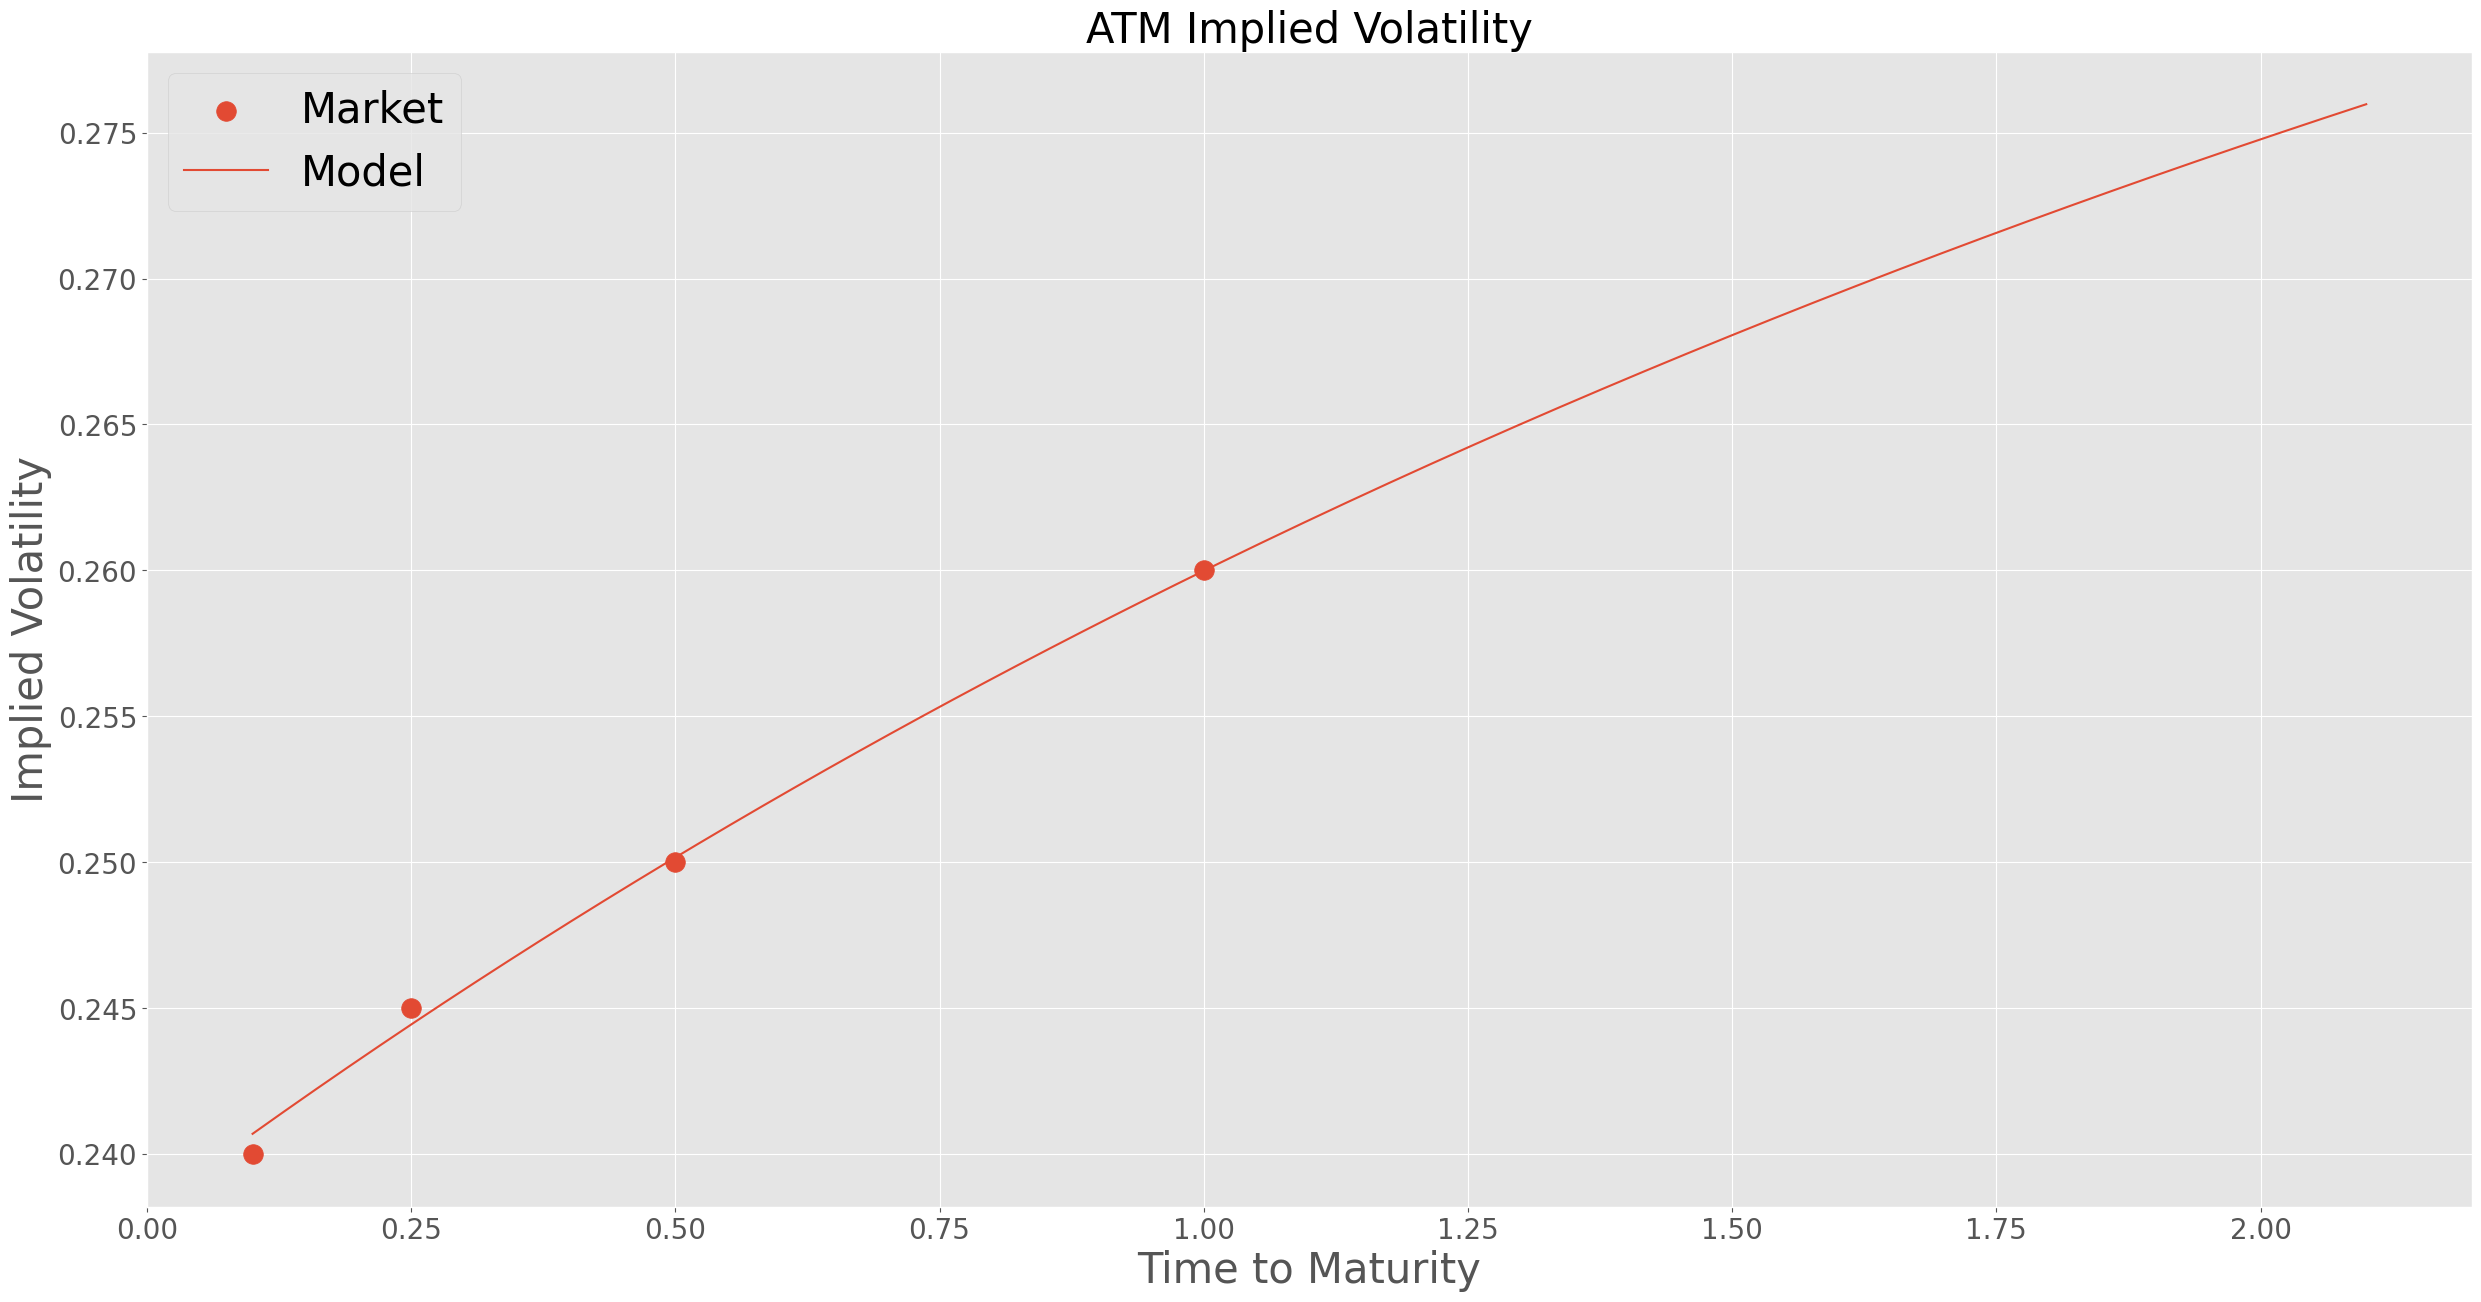

In [ ]:
t_ = np.linspace(0.1, 2.1, 200)
nu_0 = 0.2**2
nu_inf = 0.3**2
kappa = 0.5
IV_ATM = [(theta(t, *new_paramsATM)/t)**.5 for t in t_]
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.scatter(T_ATM, Vol_ATM, label="Market", s = 200)
axs.plot(t_, IV_ATM, label = "Model")
axs.set_title('ATM Implied Volatility', fontsize = 30,)
axs.set_xlabel('Time to Maturity', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show()

In [ ]:
new_params[0]

0.005135376331886448

In [ ]:
def MSE_Price_SSVI(params):
    MSE_Price = 0
    for i in range(len(MarketPrice)):
        MSE_Price = MSE_Price +\
        (CallPrice(S0, (TotalVarSSVI(S0, K[i], T[i], *new_paramsATM, *params)/T[i])**.5,\
            K[i], T[i], r) - MarketPrice[i])**2
    return MSE_Price / len(MarketPrice)
warnings.filterwarnings('ignore')
params = [1.0, -2.0, -0.5]  # initial params (eta, lambda_, rho)
result = minimize(MSE_Price_SSVI, params, method='SLSQP', tol=1e-10)
new_params = result['x']
print("Parameters [eta, lambda_, rho]: " + str(new_params))


Parameters [eta, lambda_, rho]: [ 5.13537633e-03 -4.69086188e-01 -5.65480445e+01]


In [ ]:
import numpy as np, math, random
from typing import List, Tuple
# -------------------------------------------------
# 1. Black-Scholes Call price       (no SciPy need)
# -------------------------------------------------
def normal_cdf(x):                       # Φ(x)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def bs_call_price(spot, strike, maturity, rate, vol):
    """Black-Scholes European call."""
    if vol <= 0 or maturity <= 0:
        return max(0.0, spot - strike)
    d1 = (math.log(spot / strike) + (rate + 0.5 * vol**2) * maturity) / (vol * math.sqrt(maturity))
    d2 = d1 - vol * math.sqrt(maturity)
    return (spot * normal_cdf(d1) -
            strike * math.exp(-rate * maturity) * normal_cdf(d2))

# -------------------------------------------------
# 2. SSVI helpers
# -------------------------------------------------
def atm_total_variance(t, var0, var_inf, kappa):
    """
    θ(t)  = ((var0 - var_inf)*(1 - e^{-κ t})/(κ t) + var_inf) * t
    """
    return ((var0 - var_inf) * (1 - np.exp(-kappa * t))
            / (kappa * t) + var_inf) * t

def skew_phi(theta_t, eta, lam):
    return eta * theta_t ** lam

def ssvi_total_variance(log_moneyness, theta_t, eta, lam, rho):
    phi_val = skew_phi(theta_t, eta, lam)
    term1   = rho * phi_val * log_moneyness
    term2   = np.sqrt((phi_val * log_moneyness + rho)**2 + 1 - rho**2)
    return 0.5 * theta_t * (1 + term1 + term2)

def ssvi_implied_vol(fwd, strike, maturity,
                     var0, var_inf, kappa,
                     eta, lam, rho):
    """Return σ implied by SSVI."""
    print(strike, fwd)
    k = np.log(strike / fwd)                    # log-moneyness
    theta_t = atm_total_variance(maturity, var0, var_inf, kappa)
    total_var = ssvi_total_variance(k, theta_t, eta, lam, rho)
    return np.sqrt(total_var / maturity)

# -------------------------------------------------
# 3. Example “market” surface (for demo only)
# -------------------------------------------------
rate   = 0.05
fwd    = spot = 100
maturities = np.array([0.1, 0.25, 0.5, 1.0])
strikes    = np.arange(80, 121, 5)

# Ground-truth parameters to generate fake market data
true_var0, true_var_inf, true_kappa = 0.04, 0.09, 0.4
true_eta,  true_lambda,  true_rho   = 0.8,  -0.4, -0.3

market_iv   = []
K_grid      = []
T_grid      = []

for T in maturities:
    for K in strikes:
        iv = ssvi_implied_vol(fwd, K, T,
                              true_var0, true_var_inf, true_kappa,
                              true_eta,  true_lambda,  true_rho)
        market_iv.append(iv)
        K_grid.append(K)
        T_grid.append(T)

market_iv = np.array(market_iv)
K_grid    = np.array(K_grid)
T_grid    = np.array(T_grid)

# -------------------------------------------------
# 4. Simple random-search calibration
#    (pure Python / NumPy, no external optimizer)
# -------------------------------------------------
def random_search(objective:callable, 
                  bounds: List[Tuple[float, float]], 
                  iterations:int=4000): ## Custom Optimization
    best_x, best_val = None, 1e20
    for _ in range(iterations):
        ## Bounds is a list of tuples, each tuple is (lo, hi)
        candidate = np.array([random.uniform(lo, hi) for lo, hi in bounds])
        val = objective(candidate)

        ## Update best_x and best_val if candidate is better
        if val < best_val:
            best_x, best_val = candidate, val
    return best_x

# ---- Stage-A: fit ATM term-structure (var0, var_inf, kappa)
atm_mask = K_grid == fwd
T_atm, iv_atm = T_grid[atm_mask], market_iv[atm_mask]

def atm_loss(params):
    var0, var_inf, kappa = params
    if min(params) <= 0: # keep parameters positive
        return 1e9
    model_iv = np.sqrt(atm_total_variance(T_atm, var0, var_inf, kappa) / T_atm)
    return np.mean((model_iv - iv_atm)**2)

atm_bounds = [(1e-4, 0.2), (1e-4, 0.2), (0.05, 3.0)]
var0_hat, var_inf_hat, kappa_hat = random_search(atm_loss, atm_bounds, 3000)
print(f"ATM   -> var0={var0_hat:.4f}, var_inf={var_inf_hat:.4f}, kappa={kappa_hat:.4f}")

# ---- Stage-B: fit surface (eta, lambda, rho)
def surface_loss(params):
    eta, lam, rho = params
    if eta <= 0 or not (-1 < rho < 1):
        return 1e9
    model_iv = ssvi_implied_vol(fwd, K_grid, T_grid,
                                var0_hat, var_inf_hat, kappa_hat,
                                eta, lam, rho)
    return np.mean((model_iv - market_iv)**2)

surf_bounds = [(0.05, 2.0), (-1.0, 1.0), (-0.999, 0.999)]
eta_hat, lambda_hat, rho_hat = random_search(surface_loss, surf_bounds, 4000)
print(f"Surface -> eta={eta_hat:.4f}, lambda={lambda_hat:.4f}, rho={rho_hat:.4f}")

# -------------------------------------------------
# 5. Quality check (RMSE)
# -------------------------------------------------
fitted_iv = ssvi_implied_vol(fwd, K_grid, T_grid,
                             var0_hat, var_inf_hat, kappa_hat,
                             eta_hat, lambda_hat, rho_hat)
rmse = np.sqrt(np.mean((fitted_iv - market_iv)**2))
print(f"Overall implied-vol RMSE: {rmse:.6f}")


80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
ATM   -> var0=0.0399, var_inf=0.1368, kappa=0.1978
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120


In [ ]:
import numpy as np
from typing import List, Tuple, Callable


# -------------------------------------------------
# 1. Black-Scholes Call price       (no SciPy need)
# -------------------------------------------------
def normal_cdf(x):                       # Φ(x)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def bs_call_price(spot, strike, maturity, rate, vol):
    """Black-Scholes European call."""
    if vol <= 0 or maturity <= 0:
        return max(0.0, spot - strike)
    d1 = (math.log(spot / strike) + (rate + 0.5 * vol**2) * maturity) / (vol * math.sqrt(maturity))
    d2 = d1 - vol * math.sqrt(maturity)
    return (spot * normal_cdf(d1) -
            strike * math.exp(-rate * maturity) * normal_cdf(d2))

# -------------------------------------------------
# 2. SSVI helpers
# -------------------------------------------------
def atm_total_variance(t, var0, var_inf, kappa):
    """
    θ(t)  = ((var0 - var_inf)*(1 - e^{-κ t})/(κ t) + var_inf) * t
    """
    return ((var0 - var_inf) * (1 - np.exp(-kappa * t))
            / (kappa * t) + var_inf) * t

def skew_phi(theta_t, eta, lam):
    return eta * theta_t ** lam

def ssvi_total_variance(log_moneyness, theta_t, eta, lam, rho):
    phi_val = skew_phi(theta_t, eta, lam)
    term1   = rho * phi_val * log_moneyness
    term2   = np.sqrt((phi_val * log_moneyness + rho)**2 + 1 - rho**2)
    return 0.5 * theta_t * (1 + term1 + term2)

def ssvi_implied_vol(fwd, strike, maturity,
                     var0, var_inf, kappa,
                     eta, lam, rho):
    """Return σ implied by SSVI."""
    k = np.log(strike / fwd)                    # log-moneyness
    theta_t = atm_total_variance(maturity, var0, var_inf, kappa)
    total_var = ssvi_total_variance(k, theta_t, eta, lam, rho)
    return np.sqrt(total_var / maturity)

def make_candidate(bounds: List[Tuple[float, float]], iterations) -> np.ndarray:
    """
    Generate a random candidate solution within the given bounds.
    bounds: list of (low, high) for each dimension
    """
    rng = np.random.default_rng(42)
    low  = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])

    # (iterations, d) matrix of uniform random samples
    candidates = low + (high - low) * rng.random((iterations, len(bounds)))
    return candidates


def random_search_vec(objective_multi: Callable[[np.ndarray], np.ndarray],
                      bounds: List[Tuple[float, float]],
                      iterations: int = 40_000) -> Tuple[np.ndarray, float]:
    """
    Vectorised random search.
    objective_multi: accepts an (N, d) array -> returns (N,) array of losses
    bounds         : list of (low, high) for each dimension
    iterations     : how many random draws
    """

    # vectorised loss evaluation -> (iterations,)
    candidates = make_candidate(bounds, iterations)
    losses = objective_multi(candidates)

    best_idx = np.argmin(losses)
    return candidates[best_idx], losses[best_idx]


def atm_loss_multi(X, t, iv_atm):
    """
    X : (N, 3)  – rows = [var0, var_inf, kappa]
    t, iv_atm   – market ATM maturities and vols (1-D)
    returns     – loss for each row  (shape (N,))
    """
    var0, var_inf, kappa = X[:, 0], X[:, 1], X[:, 2]
    theta_t  = atm_total_variance(t[:, None], var0, var_inf, kappa)  # broadcast
    model_iv = np.sqrt(theta_t / t[:, None])
    mse      = ((model_iv - iv_atm[:, None])**2).mean(axis=0)        # → (N,)
    return mse

def surface_loss_multi(params_mat):
    """
    params_mat : shape (N, 3) – each row [eta, lambda, rho]
    returns    : shape (N,)   – MSE per candidate
    """
    eta, lam, rho = params_mat.T                      # (N,)

    # ---- hard bounds to avoid overflow -----------------------------------
    bad = (eta <= 0) | (lam <= -0.9) | (lam >= 1.0) | (np.abs(rho) >= 0.999)
    # mark bad rows; they get a huge constant loss later
    safe_eta = np.where(bad, 1.0, eta)               # (N,)
    safe_lam = np.where(bad, 0.0, lam)
    safe_rho = np.where(bad, 0.0, rho)

    # ---- broadcast market grid (M,1) with candidates (1,N) --------------
    k  = np.log(K_grid / fwd)[:, None]                # (M,1)
    T  = T_grid[:, None]                              # (M,1)
    theta = atm_total_variance(T, var0_hat, var_inf_hat, kappa_hat)

    # each safe_* is (N,) so reshape to (1,N) for broadcasting
    total_var = ssvi_total_variance(
        k, theta,
        safe_eta[None, :], safe_lam[None, :], safe_rho[None, :]
    )                                                 # → (M,N)

    iv_model = np.sqrt(total_var / T)                 # (M,N)

    # ---- guard against any residual NaN / huge vols ----------------------
    invalid = (~np.isfinite(iv_model)) | (iv_model > 5)   # 500 % vol cutoff
    iv_model = np.where(invalid, 1e4, iv_model)           # penalise

    mse = np.mean((iv_model - market_iv[:, None])**2, axis=0)  # (N,)


    # slam the rows we flagged as ‘bad’
    mse = np.where(bad, 1e9, mse)
    return mse





In [ ]:
error_track=[]

In [ ]:
from itertools import product
width_range = np.arange(0.5, 1, 0.1)
dte_range= np.arange(0, 70, 10)
combos=list(product(width_range, dte_range))
len(combos)

35

In [ ]:


combo_choice=1
width, DTE_MIN_THRESHOLD = combos[combo_choice]
UPPER_BOUND_MONEYENESS = 1+width
LOWER_BOUND_MONEYENESS = 1-width
DTE_MAX_THRESHOLD = 730
DUMAS_WIDTH =0.75

aapl_chain['spot'] = S
aapl_chain['vol'] = aapl_chain['bs_vol']
aapl_chain['r'] = rates
aapl_chain['q'] = q
aapl_chain['price'] = aapl_chain['Midpoint']
tgt_right = 'P'

aapl_chain['DTE'] = (aapl_chain['Expiration'] - aapl_chain.index).dt.days
aapl_chain_clipped = aapl_chain[
    (aapl_chain['DTE'] >= DTE_MIN_THRESHOLD) &
    (aapl_chain['DTE'] <= DTE_MAX_THRESHOLD) &
    (aapl_chain['moneyness'] <= UPPER_BOUND_MONEYENESS) &
    (aapl_chain['moneyness'] >= LOWER_BOUND_MONEYENESS) &
    (aapl_chain['Right'] == tgt_right) 
].copy()

meta={
    'width': width,
    'UPPER_BOUND_MONEYENESS': UPPER_BOUND_MONEYENESS,
    'LOWER_BOUND_MONEYENESS': LOWER_BOUND_MONEYENESS,
    'DTE_MIN_THRESHOLD': DTE_MIN_THRESHOLD,
    'surface_loss': float
}
print(len(aapl_chain_clipped))

692


In [31]:
meta = [{'en': '0'}]
pd.DataFrame(
    meta
).en.astype(int).astype(bool)

0    False
Name: en, dtype: bool

In [ ]:
T_atm = aapl_chain_clipped[aapl_chain_clipped['moneyness'].between(0.99, 1.01)]['T'].values
iv_atm = aapl_chain_clipped[aapl_chain_clipped['moneyness'].between(0.99, 1.01)]['bs_vol'].values
fwd=aapl_chain_clipped['F'].values
K_grid = aapl_chain_clipped['Strike'].values
T_grid = aapl_chain_clipped['T'].values
rate = aapl_chain_clipped['r'].values[0]  # Assuming constant rate for all options
market_iv= aapl_chain_clipped['bs_vol'].values

,Root,Expiration,Strike,Right,Bid_size,CloseBid,Ask_size,CloseAsk,Date,Midpoint,...,log_moneyness,bs_vol,crr_vol_discrete,crr_vol_continuous,spot,vol,r,q,price,DTE
datetime,,,,,,,,,,,,,,,,,,,,,
2025-07-16,AAPL,2025-09-19,215.0,P,8,11.25,1,11.40,20250716,11.325,...,-0.015238,0.270203,0.265142,0.262993,210.160004,0.270203,0.04232,0.004806,11.325,65
2025-07-16,AAPL,2025-11-21,215.0,P,69,14.35,7,14.60,20250716,14.475,...,-0.009182,0.271078,0.263644,0.263976,210.160004,0.271078,0.04232,0.004806,14.475,128
2025-07-16,AAPL,2025-10-17,215.0,P,5,12.55,13,12.70,20250716,12.625,...,-0.013237,0.262829,0.256285,0.257443,210.160004,0.262829,0.04232,0.004806,12.625,93
2025-07-16,AAPL,2025-12-19,215.0,P,1,15.40,19,15.55,20250716,15.475,...,-0.005937,0.270703,0.262633,0.262476,210.160004,0.270703,0.04232,0.004806,15.475,156
2025-07-16,AAPL,2026-09-18,210.0,P,30,20.45,34,20.90,20250716,20.675,...,0.045507,0.284575,0.271985,0.272835,210.160004,0.284575,0.04232,0.004806,20.675,429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,AAPL,2026-09-18,205.0,P,55,18.20,48,18.85,20250716,18.525,...,0.069604,0.286575,0.275166,0.275949,210.160004,0.286575,0.04232,0.004806,18.525,429
2025-07-16,AAPL,2026-02-20,210.0,P,82,15.05,38,15.50,20250716,15.275,...,0.023651,0.275827,0.267417,0.268509,210.160004,0.275827,0.04232,0.004806,15.275,219
2025-07-16,AAPL,2026-03-20,210.0,P,33,15.90,35,16.25,20250716,16.075,...,0.026896,0.276577,0.267507,0.268212,210.160004,0.276577,0.04232,0.004806,16.075,247


In [ ]:
def get_best_params(T_atm: List[float] = T_atm,
                    iv_atm: List[float] = iv_atm) -> Tuple[np.ndarray, float]:
    """
    Find the best parameters for the ATM term structure.
    Returns:
        var0_hat, var_inf_hat, kappa_hat
    """
    bounds = [(1e-4, 0.2), # var0: Min ATM Variance across DTE
              (1e-4, 0.2), # var_inf_hat: Max ATM Variance across DTE
              (0.05, 3.0)] # kappa: Speed from var0 to var_inf_hat
    best_params, best_loss = random_search_vec(
        lambda X: atm_loss_multi(X, T_atm, iv_atm),
        bounds,
        iterations=3000
    )
    return best_params, best_loss


best_params, best_loss = get_best_params()
var0_hat, var_inf_hat, kappa_hat = best_params
print("best", best_params, "loss", best_loss)


best [0.08593553 0.07146776 2.74246497] loss 0.00016569324392814555


In [ ]:

def get_surface_params():

    # 1️⃣ tighter parameter bounds
    surf_bounds = [(0.05, 1.5),      # eta
                (-0.8, 0.8),      # lambda
                (-0.95, 0.95)]    # rho



    (eta_hat, lambda_hat, rho_hat), best_loss = random_search_vec(surface_loss_multi,
                                                        surf_bounds, 50_000)

    print(f"Surface -> eta={eta_hat:.4f}, lambda={lambda_hat:.4f}, rho={rho_hat:.4f}, loss={best_loss:.6f}")
    return eta_hat, lambda_hat, rho_hat, best_loss

eta_hat, lambda_hat, rho_hat, loss = get_surface_params()

Surface -> eta=1.3647, lambda=-0.5580, rho=0.1707, loss=0.001719


In [ ]:
from copy import deepcopy
meta = deepcopy(meta)
meta['surface_loss']=loss
error_track.append(meta)
error_track

[{'width': 0.5,
  'UPPER_BOUND_MONEYENESS': 1.5,
  'LOWER_BOUND_MONEYENESS': 0.5,
  'DTE_MIN_THRESHOLD': 10,
  'surface_loss': 0.0017186980499904025}]

## Heat Map Gen (Dirty)

In [ ]:
def clip_chain(width, DTE_MIN_THRESHOLD):
    UPPER_BOUND_MONEYENESS = 1+width
    LOWER_BOUND_MONEYENESS = 1-width
    DTE_MAX_THRESHOLD = 730
    DUMAS_WIDTH =0.75

    aapl_chain['spot'] = S
    aapl_chain['vol'] = aapl_chain['bs_vol']
    aapl_chain['r'] = rates
    aapl_chain['q'] = q
    aapl_chain['price'] = aapl_chain['Midpoint']
    tgt_right = 'P'

    aapl_chain['DTE'] = (aapl_chain['Expiration'] - aapl_chain.index).dt.days
    aapl_chain_clipped = aapl_chain[
        (aapl_chain['DTE'] >= DTE_MIN_THRESHOLD) &
        (aapl_chain['DTE'] <= DTE_MAX_THRESHOLD) &
        (aapl_chain['moneyness'] <= UPPER_BOUND_MONEYENESS) &
        (aapl_chain['moneyness'] >= LOWER_BOUND_MONEYENESS) &
        (aapl_chain['Right'] == tgt_right) 
    ].copy()

    meta={
        'width': width,
        'UPPER_BOUND_MONEYENESS': UPPER_BOUND_MONEYENESS,
        'LOWER_BOUND_MONEYENESS': LOWER_BOUND_MONEYENESS,
        'DTE_MIN_THRESHOLD': DTE_MIN_THRESHOLD,
        'surface_loss': float
    }
    return aapl_chain_clipped, meta

In [ ]:
for combo_choice in range(len(combos)):
    width, DTE_MIN_THRESHOLD = combos[combo_choice]
    UPPER_BOUND_MONEYENESS = 1+width
    LOWER_BOUND_MONEYENESS = 1-width
    DTE_MAX_THRESHOLD = 730
    DUMAS_WIDTH =0.75

    aapl_chain['spot'] = S
    aapl_chain['vol'] = aapl_chain['bs_vol']
    aapl_chain['r'] = rates
    aapl_chain['q'] = q
    aapl_chain['price'] = aapl_chain['Midpoint']
    tgt_right = 'P'

    aapl_chain['DTE'] = (aapl_chain['Expiration'] - aapl_chain.index).dt.days
    aapl_chain_clipped = aapl_chain[
        (aapl_chain['DTE'] >= DTE_MIN_THRESHOLD) &
        (aapl_chain['DTE'] <= DTE_MAX_THRESHOLD) &
        (aapl_chain['moneyness'] <= UPPER_BOUND_MONEYENESS) &
        (aapl_chain['moneyness'] >= LOWER_BOUND_MONEYENESS) &
        (aapl_chain['Right'] == tgt_right) 
    ].copy()

    meta={
        'width': width,
        'UPPER_BOUND_MONEYENESS': UPPER_BOUND_MONEYENESS,
        'LOWER_BOUND_MONEYENESS': LOWER_BOUND_MONEYENESS,
        'DTE_MIN_THRESHOLD': DTE_MIN_THRESHOLD,
        'surface_loss': float
    }
    print(len(aapl_chain_clipped))


    T_atm = aapl_chain_clipped[aapl_chain_clipped['moneyness'].between(0.99, 1.01)]['T'].values
    iv_atm = aapl_chain_clipped[aapl_chain_clipped['moneyness'].between(0.99, 1.01)]['bs_vol'].values
    fwd=aapl_chain_clipped['F'].values
    K_grid = aapl_chain_clipped['Strike'].values
    T_grid = aapl_chain_clipped['T'].values
    rate = aapl_chain_clipped['r'].values[0]  # Assuming constant rate for all options
    market_iv= aapl_chain_clipped['bs_vol'].values

    best_params, best_loss = get_best_params()
    var0_hat, var_inf_hat, kappa_hat = best_params


    eta_hat, lambda_hat, rho_hat, loss = get_surface_params()
    model_params={
        'var0': var0_hat,
        'var_inf': var_inf_hat,
        'kappa': kappa_hat,
        'eta': eta_hat,
        'lambda': lambda_hat,
        'rho': rho_hat
    }

    meta = deepcopy(meta)
    meta['surface_loss']=loss
    meta['model_params'] = model_params
    error_track.append(meta)
    print(f"Combo {combo_choice} done: {meta}")

799
Surface -> eta=0.5167, lambda=-0.7738, rho=0.1859, loss=0.009275
Combo 0 done: {'width': 0.5, 'UPPER_BOUND_MONEYENESS': 1.5, 'LOWER_BOUND_MONEYENESS': 0.5, 'DTE_MIN_THRESHOLD': 0, 'surface_loss': 0.009274805451422277, 'model_params': {'var0': 0.08593552625319342, 'var_inf': 0.0714677580702203, 'kappa': 2.742464972687961, 'eta': 0.5166832104763232, 'lambda': -0.7738163963606741, 'rho': 0.1859082946782078}}
692
Surface -> eta=1.3647, lambda=-0.5580, rho=0.1707, loss=0.001719
Combo 1 done: {'width': 0.5, 'UPPER_BOUND_MONEYENESS': 1.5, 'LOWER_BOUND_MONEYENESS': 0.5, 'DTE_MIN_THRESHOLD': 10, 'surface_loss': 0.0017186980499904025, 'model_params': {'var0': 0.08593552625319342, 'var_inf': 0.0714677580702203, 'kappa': 2.742464972687961, 'eta': 1.3647232156447906, 'lambda': -0.5579741254492856, 'rho': 0.17065046704197506}}
641
Surface -> eta=1.3647, lambda=-0.5580, rho=0.1707, loss=0.001429
Combo 2 done: {'width': 0.5, 'UPPER_BOUND_MONEYENESS': 1.5, 'LOWER_BOUND_MONEYENESS': 0.5, 'DTE_MIN_TH

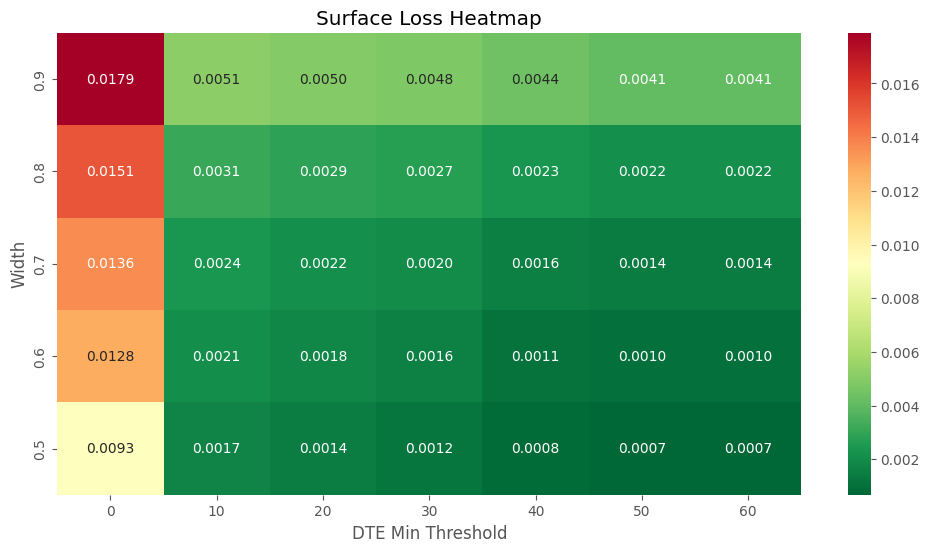

In [ ]:
error_df = pd.DataFrame(error_track)
## Plot Heat Map
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# heatmap_data = error_df.pivot(index="width", columns="DTE_MIN_THRESHOLD",values="surface_loss")
heatmap_data = error_df.pivot_table(
    index="width", 
    columns="DTE_MIN_THRESHOLD", 
    values="surface_loss", 
    aggfunc='mean'
)
heatmap_data.index = heatmap_data.index.round(2)
heatmap_data=heatmap_data.iloc[::-1]
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="RdYlGn_r")
plt.title("Surface Loss Heatmap")
plt.xlabel("DTE Min Threshold")
plt.ylabel("Width")
plt.show()

In [ ]:
heatmap_data

DTE_MIN_THRESHOLD,0,10,20,30,40,50,60
width,,,,,,,
0.9,0.017889,0.005124,0.004981,0.004818,0.004378,0.004076,0.004076
0.8,0.015102,0.003120,0.002885,0.002726,0.002321,0.002151,0.002151
0.7,0.013599,0.002410,0.002151,0.001974,0.001550,0.001365,0.001365
0.6,0.012756,0.002089,0.001802,0.001582,0.001113,0.000968,0.000968
0.5,0.009275,0.001719,0.001429,0.001190,0.000825,0.000680,0.000680


In [ ]:
from typing import Literal
def plot_subplot(
    grid: pd.DataFrame, 
    x: Literal['column', 'index'],
    label: str = 'Value',
    sup_tile: str = '3x2 Subplot Visualization',
    subplot_title_format: list = None,
    nrows: int = 3,
    ncols: int = 2
):
    if subplot_title_format is None:
        subplot_title_format = "Plot for {x}"
    if not isinstance(subplot_title_format, list):
        subplot_title_format = [subplot_title_format] * len(grid.columns)
    grid=grid.copy().T if x=='column' else grid.copy()
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    idx=0
    for r in range(nrows):
        for c in range(ncols):
   
            if idx > len(grid.columns) -1:
                break
            x_values = grid.index
            y_values = grid.iloc[:, idx]

            ax[r, c].plot(x_values, y_values, marker='o', linestyle='-', label=label)
            ax[r, c].set_title(subplot_title_format[idx])
            idx += 1
    fig.suptitle(sup_tile)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])



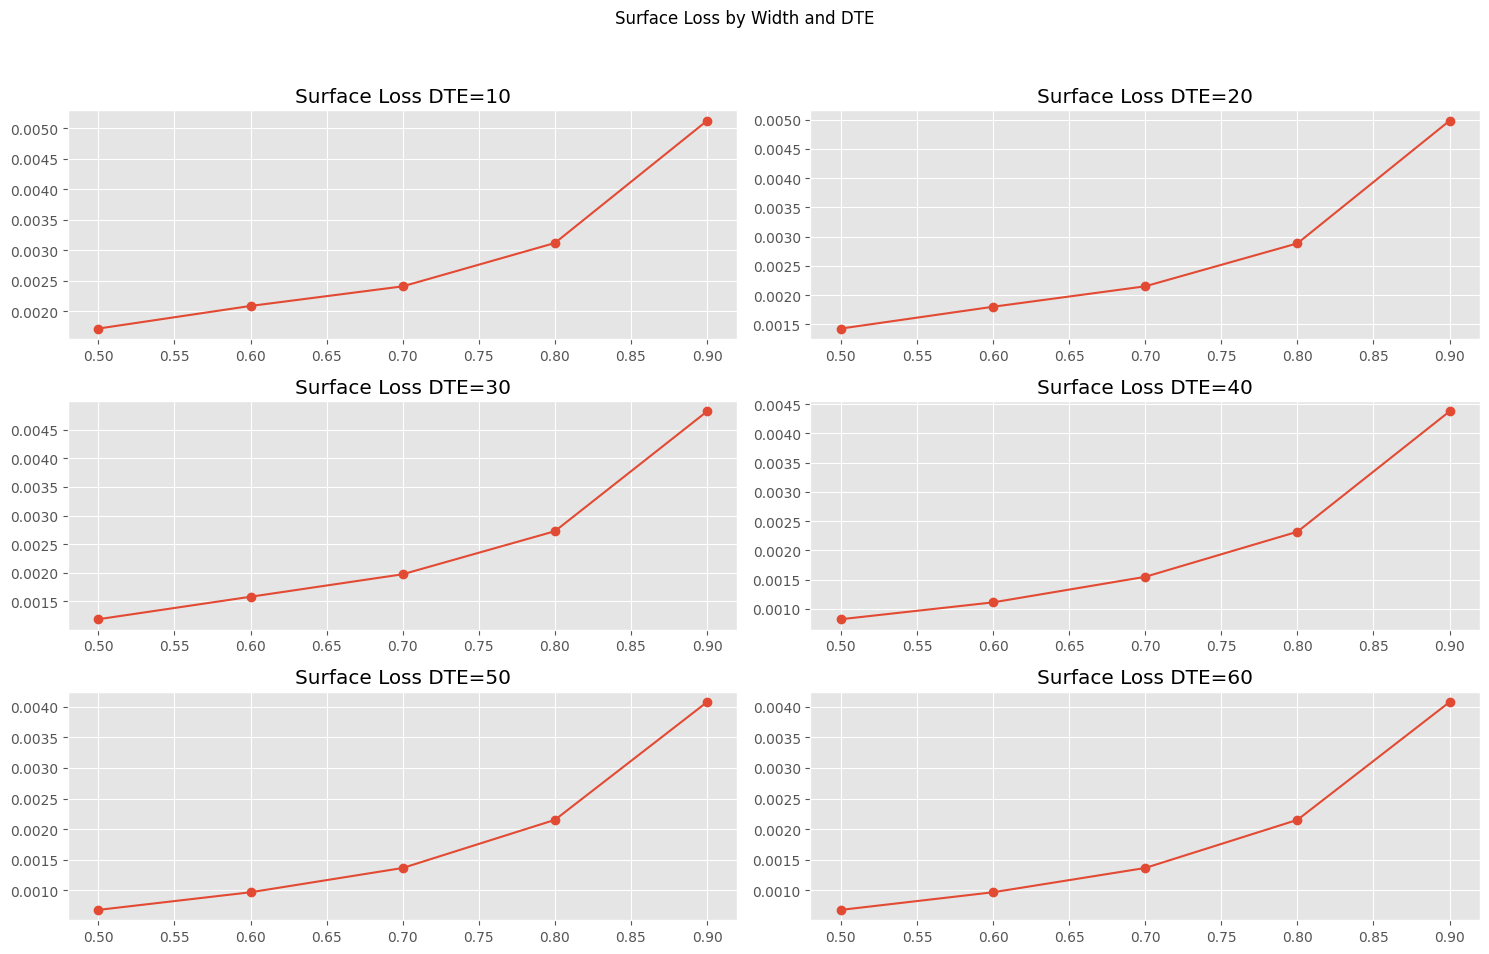

In [ ]:
grid_use=heatmap_data.copy().iloc[:, 1:]
sub_titles = [f"Surface Loss DTE={dte}" for  dte in grid_use.columns]
plot_subplot(
    grid=grid_use, 
    x='index', 
    label='Surface Loss', 
    sup_tile='Surface Loss by Width and DTE',
    subplot_title_format=sub_titles
)

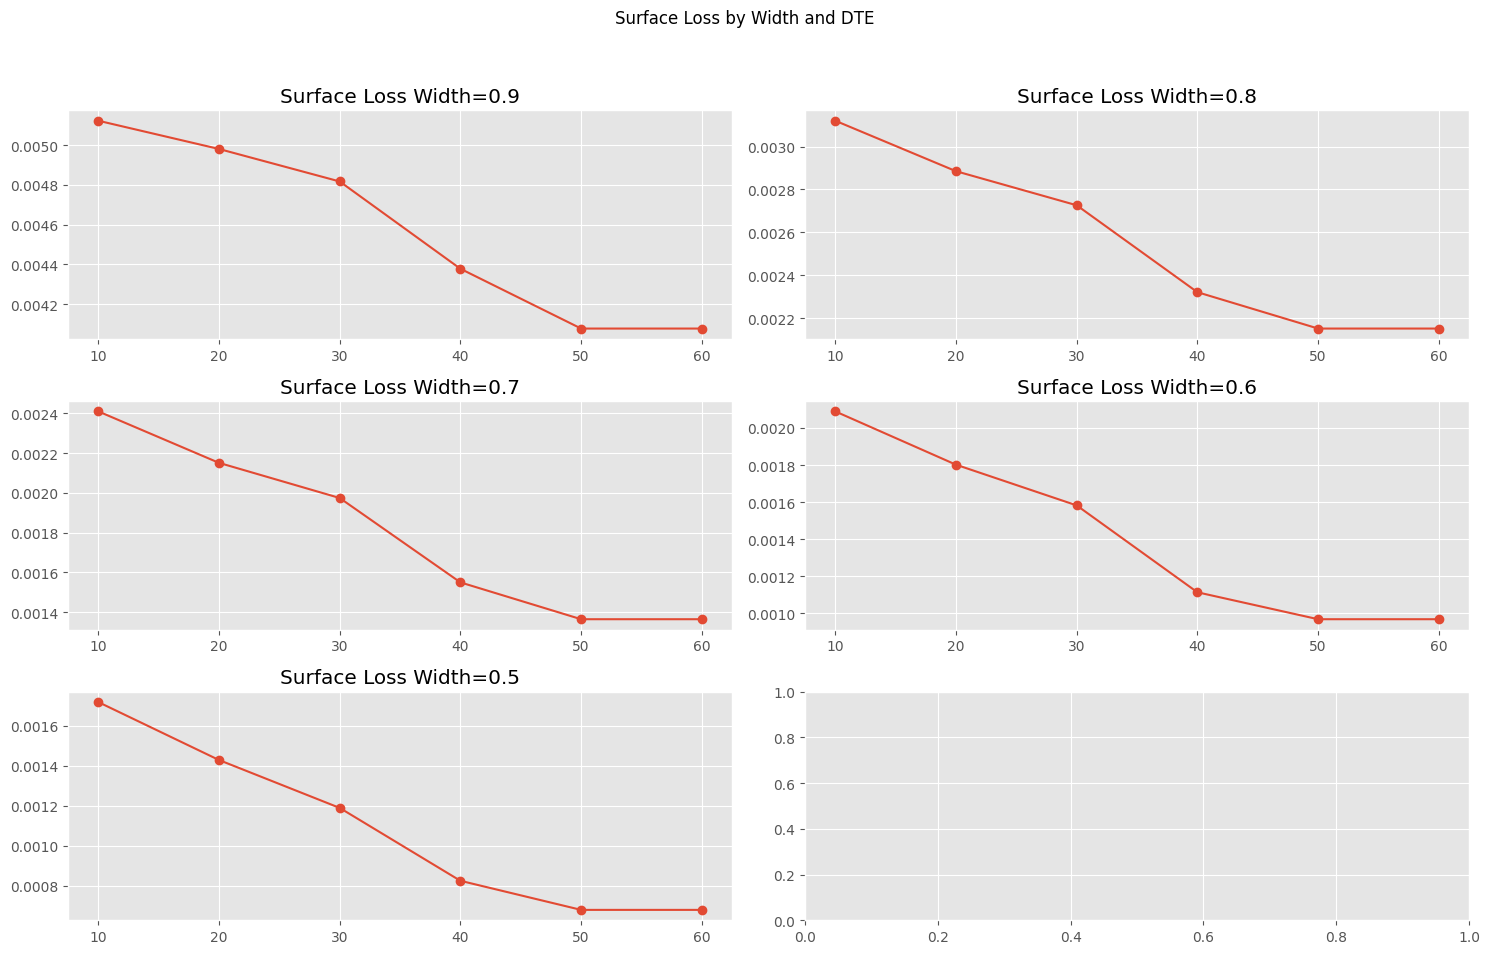

In [ ]:
grid_use=heatmap_data.copy().iloc[:, 1:]
sub_titles = [f"Surface Loss Width={width}" for  width in grid_use.index]
plot_subplot(
    grid=grid_use, 
    x='column', 
    label='Surface Loss', 
    sup_tile='Surface Loss by Width and DTE',
    subplot_title_format=sub_titles
)

In [ ]:
params = error_df[(error_df.width==0.8) &
                  (error_df.DTE_MIN_THRESHOLD==30)].sort_values('surface_loss').model_params.values[0]
params


{'var0': 0.08593552625319342,
 'var_inf': 0.0714677580702203,
 'kappa': 2.742464972687961,
 'eta': 1.4015869600327218,
 'lambda': -0.5842413276491021,
 'rho': 0.20172681953864702}

In [ ]:
# aapl_chain_clipped_lab

tgt_right='P'
T_use=aapl_chain_clipped_lab['T'].unique()[11]
dte_use=aapl_chain_clipped_lab[aapl_chain_clipped_lab['T']==T_use]['DTE'].values[0]
dte_calc=T_use * 365.25
T_grid= aapl_chain_clipped_lab['T'].values
T_use_mask = T_grid ==T_use
C_index = aapl_chain_clipped_lab['Right'] == tgt_right
T_use_index = np.where(T_use_mask & C_index)
var0_hat = params['var0']
var_inf_hat = params['var_inf']
kappa_hat = params['kappa']
eta_hat = params['eta']
lambda_hat = params['lambda']
rho_hat = params['rho']

K_grid= aapl_chain_clipped_lab['Strike'].values
fwd = aapl_chain_clipped_lab['F'].values
market_iv = aapl_chain_clipped_lab['bs_vol'].values
K_use = K_grid[T_use_index]
fwd_use = fwd[T_use_index]
log_moneyness = np.log(K_use / fwd_use)
market_iv_use = market_iv[T_use_index]
model_use = ssvi_implied_vol(
    fwd_use, K_use, T_use,
    var0_hat, var_inf_hat, kappa_hat,
    eta_hat, lambda_hat, rho_hat
)
model_use
dte_use, tgt_right

(219, 'P')

In [ ]:
vols = lab.predict(
    dte = float(dte_use),
    k= K_use,
    right='P'
)

dumas=vols['dumas']
svi=vols['svi']
svi_rmse = np.sqrt(np.mean((svi - market_iv_use)**2))
dumas_rmse = np.sqrt(np.mean((dumas - market_iv_use)**2))
model_rmse = np.sqrt(np.mean((model_use - market_iv_use)**2))
print(f"SVI RMSE: {svi_rmse:.4f}, Dumas RMSE: {dumas_rmse:.4f}, Model RMSE: {model_rmse:.4f}")
vols.pop('dumas')

SVI RMSE: 0.0770, Dumas RMSE: 0.0884, Model RMSE: 0.0289


array([0.26430563, 0.25947963, 0.25486334, 0.25044534, 0.24621503,
       0.24216258, 0.23827885, 0.23455532, 0.23098402, 0.22755756,
       0.22426897, 0.22111177, 0.21807986, 0.21516752, 0.21236937,
       0.20968038, 0.20709577, 0.20461107, 0.19992472, 0.45102003,
       0.43587886, 0.42174918, 0.4085337 , 0.39614772, 0.38451709,
       0.37357657, 0.36326852, 0.35354175, 0.34435066, 0.33565446,
       0.32741653, 0.3196039 , 0.31218679, 0.30513821, 0.29843365,
       0.29205079, 0.28596925, 0.28017039, 0.2746371 , 0.26935367])

In [ ]:
full_data = pd.DataFrame(vols).set_index('k')
full_data['ssvi']= model_use
full_data['market_iv'] = market_iv_use
full_data.sort_index(inplace=True)
full_data.plot(

    title=f"Volatility Surface for DTE={dte_use} days",
)

In [ ]:
dataframe_vols = pd.DataFrame({
    'K': K_use,
    'log_moneyness': log_moneyness,
    'market_iv': market_iv_use,
    'model_iv': model_use
})
dataframe_vols.sort_values('log_moneyness').plot(
    x='log_moneyness',
    y=['market_iv', 'model_iv'],
    kind='line',
    title=f'SSVI Volatility Surface at T={T_use:.2f} years'

)

In [ ]:
fwd[0],\
K_grid[0],\
T_grid[0],\
market_iv[0]

(211.06290118921353, 215.0, 0.10130047912388775, 0.29094924873121825)

In [ ]:
def as_column(a):
    """Return a (len,1) column regardless of original rank."""
    return np.asarray(a).reshape(-1, 1)

def as_row(a):
    """Return a (1,len) row regardless of original rank."""
    return np.asarray(a).reshape(1, -1)


In [ ]:
# -------------------------------------------------
# 6. Plot: market IV (dots) vs SSVI fit (lines)
# -------------------------------------------------
import matplotlib.pyplot as plt

unique_T = np.unique(T_grid)
color_map = plt.cm.viridis(np.linspace(0, 1, len(unique_T)))

plt.figure(figsize=(9, 5))
for idx, maturity in enumerate(unique_T):
    sel = T_grid == maturity
    k_vals      = np.log(K_grid[sel] / fwd)          # log-moneyness
    iv_market   = market_iv[sel]
    iv_model    = fitted_iv[sel]

    plt.scatter(k_vals, iv_market, color=color_map[idx],
                label=f"T={maturity:.2f}  market", marker='o')
    plt.plot   (k_vals, iv_model,  color=color_map[idx],
                label=f"T={maturity:.2f}  model")

plt.title("SSVI fit vs. market implied vols")
plt.xlabel("log-moneyness  k = ln(K/F)")
plt.ylabel("Implied volatility")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()



ValueError: operands could not be broadcast together with shapes (43,) (649,) 

<Figure size 900x500 with 0 Axes>